In [ ]:
import torch

import random
import numpy as np

SEED = 1234

random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.backends.cudnn.deterministic = True

In [ ]:
!pip install transformers==3

from transformers import BertTokenizer

     |████████████████████████████████| 757kB 5.8MB/s 
     |████████████████████████████████| 3.0MB 9.3MB/s 
     |████████████████████████████████| 1.2MB 35.9MB/s 
     |████████████████████████████████| 870kB 38.7MB/s 
  Created wheel for sacremoses: filename=sacremoses-0.0.44-cp37-none-any.whl size=886084 sha256=011cbdc94940f6912fa6ce0c7d484ab919170ba278749c190f1db2a86624d1ba
  Stored in directory: /root/.cache/pip/wheels/3e/fb/c0/13ab4d63d537658f448366744654323077c4d90069b6512f3c
Successfully built sacremoses


In [ ]:
from google.colab import drive
drive.mount('/content/drive/')

import os
os.chdir('/content/drive/MyDrive')
!ls


In [ ]:
cd CZ4034/

/content/drive/MyDrive/CZ4034


In [ ]:
import pandas as pd

In [ ]:
PRE_TRAINED_MODEL_NAME = 'bert-base-cased'

tokenizer = BertTokenizer.from_pretrained(PRE_TRAINED_MODEL_NAME)
len(tokenizer.vocab)

28996

In [ ]:
from torch.utils.data import Dataset, DataLoader
class ReviewDataset(Dataset):
  def __init__(self, reviews, targets, tokenizer, max_len):
    self.reviews = reviews
    self.targets = targets
    self.tokenizer = tokenizer
    self.max_len = max_len
    
  def __len__(self):
    return len(self.reviews)

  def __getitem__(self, item):
    review = str(self.reviews[item])
    target = self.targets[item]
    encoding = self.tokenizer.encode_plus(
      review,
      add_special_tokens=True,
      max_length=self.max_len,
      return_token_type_ids=False,
      pad_to_max_length=True,
      return_attention_mask=True,
      return_tensors='pt',
      truncation=True
    )

    return {
      'review_text': review,
      'input_ids': encoding['input_ids'].flatten(),
      'attention_mask': encoding['attention_mask'].flatten(),
      'targets': torch.tensor(target, dtype=torch.long)
    }

In [ ]:
import numpy as np
RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)
torch.manual_seed(RANDOM_SEED)


In [ ]:
df_train = pd.read_csv("shared_train_set.csv")
df_test = pd.read_csv("shared_test_set.csv")



In [ ]:
df_train_neutral = df_train[df_train['label'] == 0]
df_train_pos = df_train[df_train['label'] == 1]
df_train_neg = df_train[df_train['label'] == 2]
df_train_neutral.shape, df_train_pos.shape, df_train_neg.shape

((390, 2), (422, 2), (377, 2))

In [ ]:
df_test_neutral = df_test[df_test['label'] == 0]
df_test_pos = df_test[df_test['label'] == 1]
df_test_neg = df_test[df_test['label'] == 2]
df_test_neutral.shape, df_test_pos.shape, df_test_neg.shape

((110, 2), (94, 2), (94, 2))

In [ ]:
df_train_polarity = pd.concat([df_train_pos,df_train_neg]).sample(390)

In [ ]:
df_test_polarity = pd.concat([df_test_pos, df_test_neg]).sample(110)

In [ ]:
df_train = pd.concat([df_train_polarity, df_train_neutral]).sample(frac = 1)
df_test = pd.concat([df_test_polarity, df_test_neutral]).sample(frac = 1)

In [ ]:
def convert_numerical(x):
    if x==0:
      return 0
    return 1

df_train['label'] = df_train['label'].apply(convert_numerical)
df_test['label'] = df_test['label'].apply(convert_numerical)
df_train.label.value_counts()

1    390
0    390
Name: label, dtype: int64

In [ ]:
df_test.label.value_counts()

1    110
0    110
Name: label, dtype: int64

In [ ]:
from sklearn.model_selection import train_test_split
df_train, df_val = train_test_split(
  df_train,
  test_size=0.2,
  random_state=RANDOM_SEED
)

In [ ]:
def create_data_loader(df, tokenizer, max_len, batch_size):
  ds = ReviewDataset(
    reviews=df['text'].to_numpy(),
    targets=df['label'].to_numpy(),
    tokenizer=tokenizer,
    max_len=max_len
  )
  return DataLoader(
    ds,
    batch_size=batch_size,
    num_workers=2
  )

from transformers import BertModel, BertTokenizer, AdamW, get_linear_schedule_with_warmup
from torch import nn, optim

class SentimentClassifier(nn.Module):
  def __init__(self, n_classes):
    super(SentimentClassifier, self).__init__()
    self.bert = BertModel.from_pretrained(PRE_TRAINED_MODEL_NAME)
    self.drop = nn.Dropout(p=0.2)
    self.out = nn.Linear(self.bert.config.hidden_size, n_classes)
  def forward(self, input_ids, attention_mask):
    _, pooled_output = self.bert(
      input_ids=input_ids,
      attention_mask=attention_mask
    )
    output = self.drop(pooled_output)
    return self.out(output)

def train_epoch(
  model,
  data_loader,
  loss_fn,
  optimizer,
  device,
  scheduler,
  n_examples
):
  model = model.train()
  losses = []
  correct_predictions = 0
  for d in data_loader:
    input_ids = d["input_ids"].to(device)
    attention_mask = d["attention_mask"].to(device)
    targets = d["targets"].to(device)
    outputs = model(
      input_ids=input_ids,
      attention_mask=attention_mask
    )
    _, preds = torch.max(outputs, dim=1)
    loss = loss_fn(outputs, targets)
    correct_predictions += torch.sum(preds == targets)
    losses.append(loss.item())
    loss.backward()
    nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
    optimizer.step()
    scheduler.step()
    optimizer.zero_grad()
  return correct_predictions.double() / n_examples, np.mean(losses)

def eval_model(model, data_loader, loss_fn, device, n_examples):
  model = model.eval()
  losses = []
  correct_predictions = 0
  with torch.no_grad():
    for d in data_loader:
      input_ids = d["input_ids"].to(device)
      attention_mask = d["attention_mask"].to(device)
      targets = d["targets"].to(device)
      outputs = model(
        input_ids=input_ids,
        attention_mask=attention_mask
      )
      _, preds = torch.max(outputs, dim=1)
      loss = loss_fn(outputs, targets)
      correct_predictions += torch.sum(preds == targets)
      losses.append(loss.item())
  return correct_predictions.double() / n_examples, np.mean(losses)


In [ ]:
MAX_LEN = 250

BATCH_SIZE = 4
train_data_loader = create_data_loader(df_train, tokenizer, MAX_LEN, BATCH_SIZE)
val_data_loader = create_data_loader(df_val, tokenizer, MAX_LEN, BATCH_SIZE)
test_data_loader = create_data_loader(df_test, tokenizer, MAX_LEN, BATCH_SIZE)

model = SentimentClassifier(2)
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model = model.to(device)

EPOCHS = 25
optimizer = AdamW(model.parameters(), lr=2e-5, correct_bias=False)
total_steps = len(train_data_loader) * EPOCHS
scheduler = get_linear_schedule_with_warmup(
  optimizer,
  num_warmup_steps=0,
  num_training_steps=total_steps
)
loss_fn = nn.CrossEntropyLoss().to(device)

In [ ]:
%%time
from collections import defaultdict
history = defaultdict(list)
best_accuracy = 0
for epoch in range(EPOCHS):
  print(f'Epoch {epoch + 1}/{EPOCHS}')
  print('-' * 10)
  train_acc, train_loss = train_epoch(
    model,
    train_data_loader,
    loss_fn,
    optimizer,
    device,
    scheduler,
    len(df_train)
  )
  print(f'Train loss {train_loss} accuracy {train_acc}')
  val_acc, val_loss = eval_model(
    model,
    val_data_loader,
    loss_fn,
    device,
    len(df_val)
  )
  print(f'Val   loss {val_loss} accuracy {val_acc}')
  print()
  history['train_acc'].append(train_acc)
  history['train_loss'].append(train_loss)
  history['val_acc'].append(val_acc)
  history['val_loss'].append(val_loss)
  if val_acc > best_accuracy:
    torch.save(model.state_dict(), 'best_model_state_subjectivity_shared_set.bin')
    best_accuracy = val_acc

Epoch 1/25
----------
Train loss 0.743105542105742 accuracy 0.47115384615384615
Val   loss 0.7185234396885603 accuracy 0.49358974358974356

Epoch 2/25
----------
Train loss 0.6920162679102176 accuracy 0.5576923076923077
Val   loss 0.5663520991802216 accuracy 0.6987179487179487

Epoch 3/25
----------
Train loss 0.6261259672703604 accuracy 0.7227564102564102
Val   loss 0.5929715226476009 accuracy 0.75

Epoch 4/25
----------
Train loss 0.34045131463081374 accuracy 0.8878205128205128
Val   loss 1.3711112854757512 accuracy 0.7371794871794871

Epoch 5/25
----------
Train loss 0.14582914019345666 accuracy 0.9631410256410257
Val   loss 2.2870357991938737 accuracy 0.673076923076923

Epoch 6/25
----------
Train loss 0.02932066464577824 accuracy 0.9951923076923077
Val   loss 2.3798138377981863 accuracy 0.7051282051282051

Epoch 7/25
----------
Train loss 0.010908549950260912 accuracy 0.9951923076923077
Val   loss 2.158380703517674 accuracy 0.717948717948718

Epoch 8/25
----------
Train loss 0.011

In [ ]:
def get_predictions(model, data_loader):
  model = model.eval()
  review_texts = []
  predictions = []
  prediction_probs = []
  real_values = []
  with torch.no_grad():
    for d in data_loader:
      texts = d["review_text"]
      input_ids = d["input_ids"].to(device)
      attention_mask = d["attention_mask"].to(device)
      targets = d["targets"].to(device)
      outputs = model(
        input_ids=input_ids,
        attention_mask=attention_mask
      )
      _, preds = torch.max(outputs, dim=1)
      review_texts.extend(texts)
      predictions.extend(preds)
      prediction_probs.extend(outputs)
      real_values.extend(targets)
  predictions = torch.stack(predictions).cpu()
  prediction_probs = torch.stack(prediction_probs).cpu()
  real_values = torch.stack(real_values).cpu()
  return review_texts, predictions, prediction_probs, real_values

In [ ]:
y_review_texts, y_pred, y_pred_probs, y_test = get_predictions(
  model,
  test_data_loader
)

In [ ]:
from sklearn.metrics import confusion_matrix, classification_report
class_names = ['neutral', 'polarised']
print(classification_report(y_test, y_pred, target_names=class_names))

              precision    recall  f1-score   support

     neutral       0.73      0.76      0.75       102
   polarised       0.74      0.70      0.72        98

    accuracy                           0.73       200
   macro avg       0.74      0.73      0.73       200
weighted avg       0.74      0.73      0.73       200



In [ ]:
import pickle
pickle.dump(history,open('train_bert_subjectivity_train_history_shared_0.73.pkl','wb'))

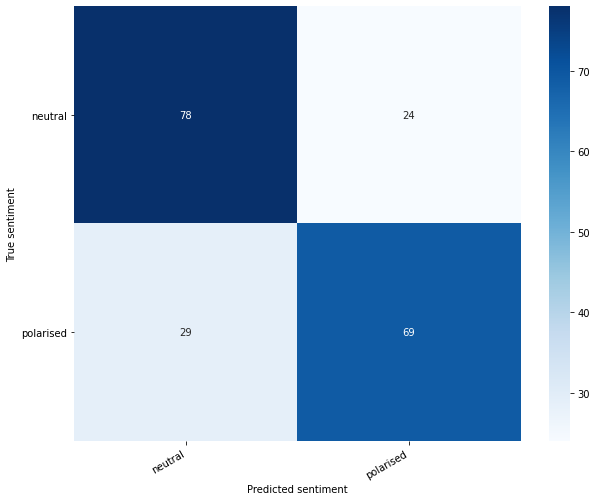

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
def show_confusion_matrix(confusion_matrix):
  plt.figure(figsize=(10,8))
  hmap = sns.heatmap(confusion_matrix, annot=True, fmt="d", cmap="Blues")
  hmap.yaxis.set_ticklabels(hmap.yaxis.get_ticklabels(), rotation=0, ha='right')
  hmap.xaxis.set_ticklabels(hmap.xaxis.get_ticklabels(), rotation=30, ha='right')
  
  plt.ylabel('True sentiment')
  plt.xlabel('Predicted sentiment');
cm = confusion_matrix(y_test, y_pred)
df_cm = pd.DataFrame(cm, index=class_names, columns=class_names)
show_confusion_matrix(df_cm)